In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import tree
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.cross_validation import KFold,train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,mean_squared_error
import graphviz as gv
%matplotlib inline

In [4]:
#read data
hitters_df = pd.read_csv('data/Hitters.csv')
hitters_df.dropna(inplace=True)
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


###Tree Regression

In [6]:
collists = ['Years','Hits']
X = hitters_df[collists].values
y = hitters_df['Salary'].values
# log transform to y
y_log = [np.log2(i) for i in y]

In [7]:
# fit data
clf = tree.DecisionTreeRegressor()
clf.fit(X,y_log)
clf.feature_importances_

array([ 0.62133897,  0.37866103])

In [9]:
# Visualise tree
dot_data = StringIO()
tree.export_graphviz(clf,out_file= dot_data)
data = open('hitter.dot','r').read()
#graph = pydot.graph_from_dot_file('hitter.dot')

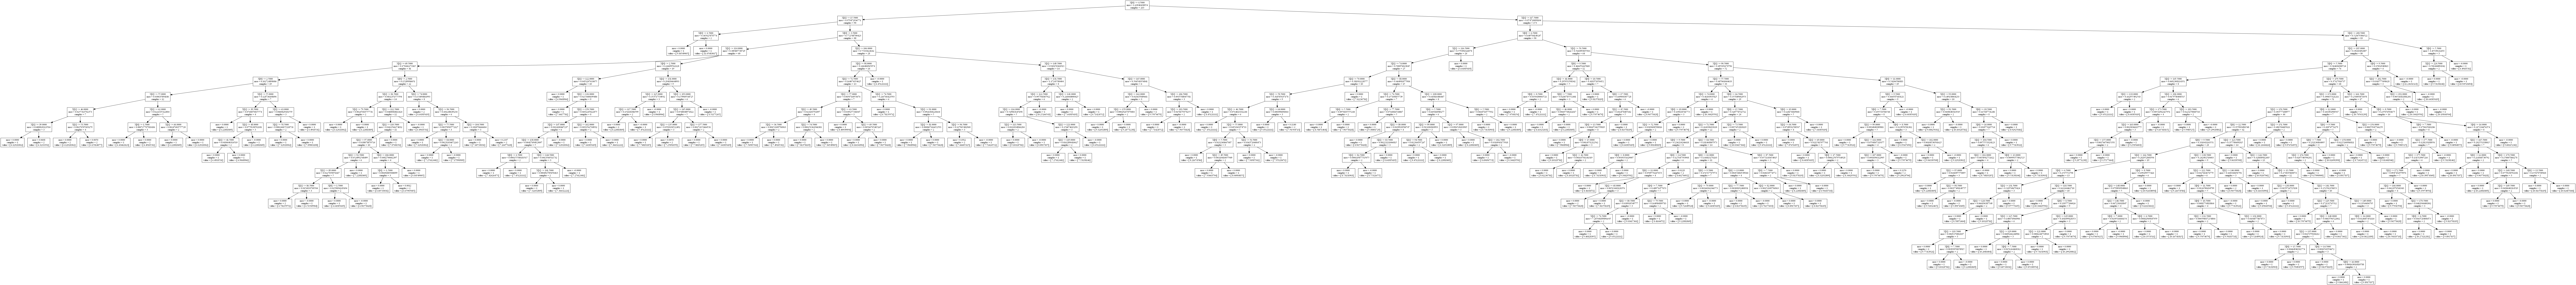

In [33]:
g = gv.Source(data)
g.format = 'png'
g.render()
Image('Source.gv.png')
#we can see this tree is so bad beacause overfitting

###BaggingRegressor

In [2]:
from sklearn.ensemble import BaggingRegressor

In [8]:
breg = BaggingRegressor()
breg.fit(X,y_log)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0)

In [12]:
ypred = breg.predict(X)

In [15]:
mean_squared_error(ypred,y_log)

0.10130437936966444

###Classfication

In [5]:
carseats_df = pd.read_csv('data/Carseats.csv')
#recode Sales
carseats_df["High"] = carseats_df["Sales"].map(lambda x : 0 if x <=8 else 1)
carseats_df["ShelveLoc"] = pd.factorize(carseats_df['ShelveLoc'])[0]
carseats_df["Urban"] = pd.factorize(carseats_df['Urban'])[0]
carseats_df["US"] = pd.factorize(carseats_df['US'])[0]
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,0,0,1
1,11.22,111,48,16,260,83,1,65,10,0,0,1
2,10.06,113,35,10,269,80,2,59,12,0,0,1
3,7.40,117,100,4,466,97,2,55,14,0,0,0
4,4.15,141,64,3,340,128,0,38,13,0,1,0


In [45]:
collist = [col for col in carseats_df.columns if col != 'Sales' and col !='High']
X = carseats_df[collist].values
y = carseats_df['High'].values

#fit by decision tree
dt = tree.DecisionTreeClassifier()
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [46]:
#Visualise tree
dot_data = StringIO()
tree.export_graphviz(dt,out_file=dot_data)
data = dot_data.getvalue()
g = gv.Source(data)
g.format = 'png'
g.filename = 'tree1'
g.render()

'tree1.png'

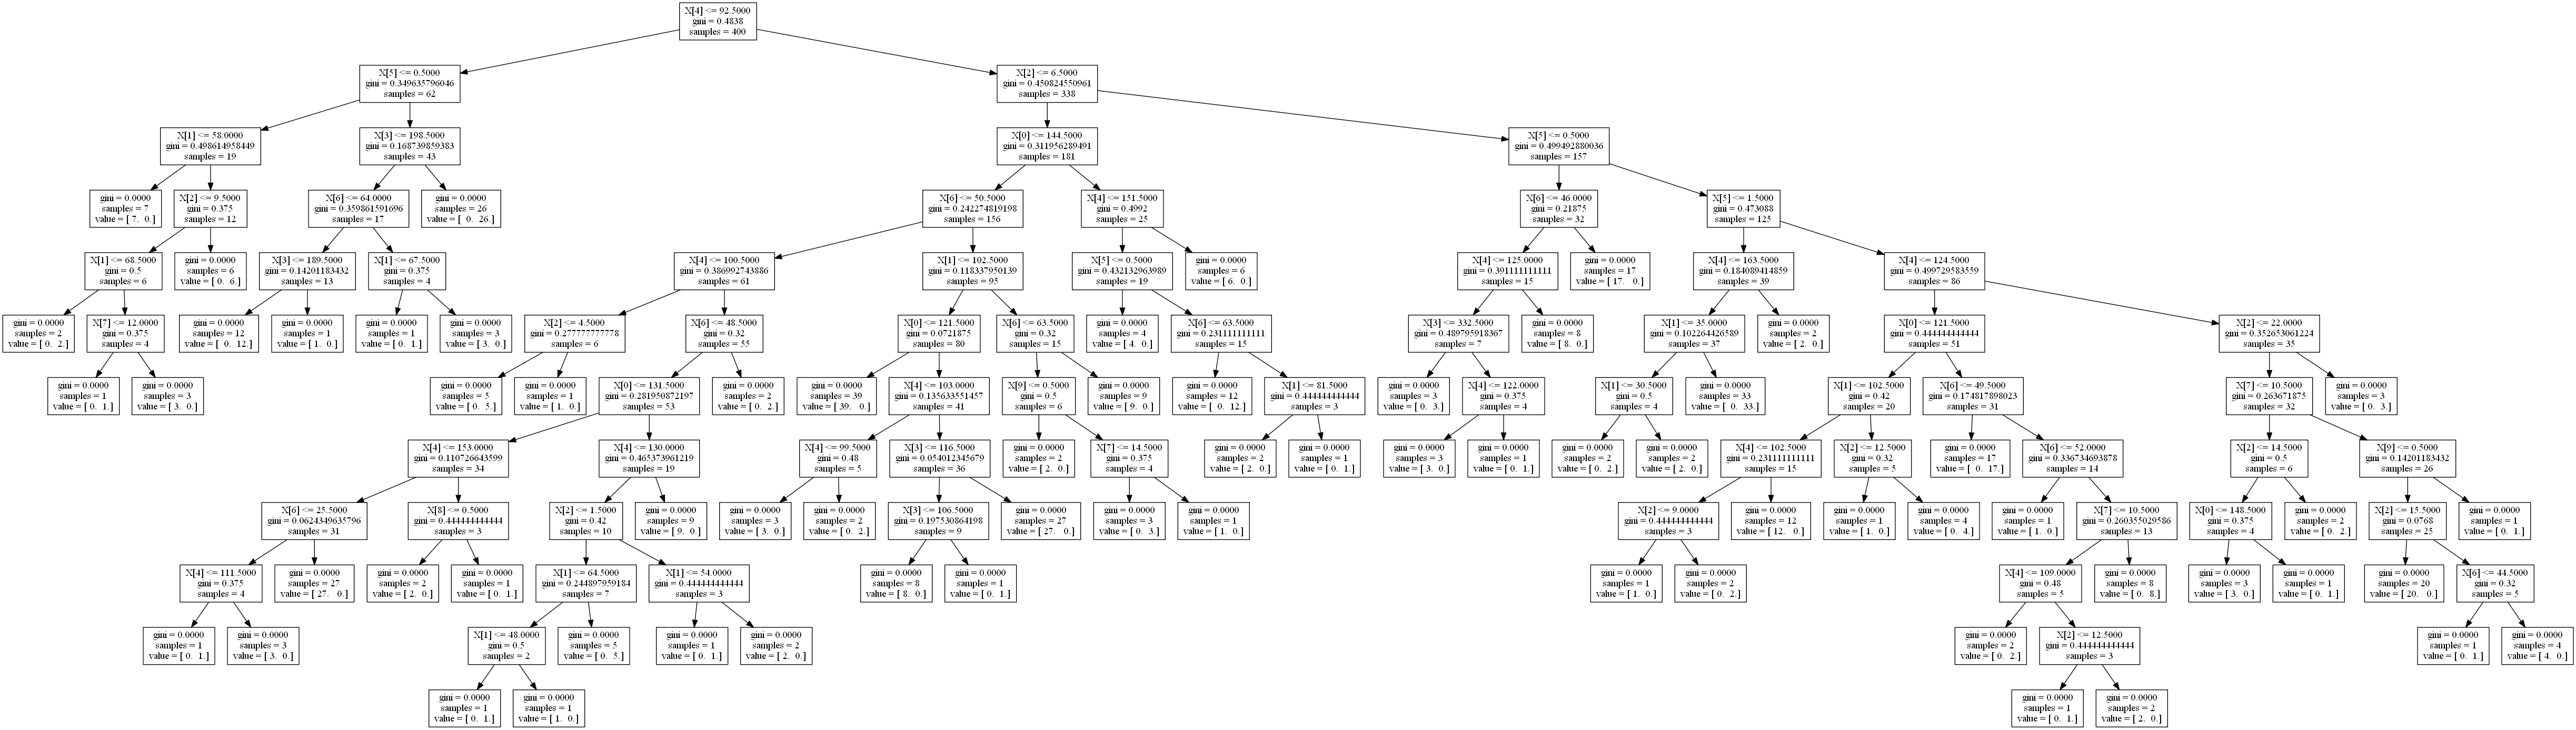

In [47]:
#show
Image('tree1.png')

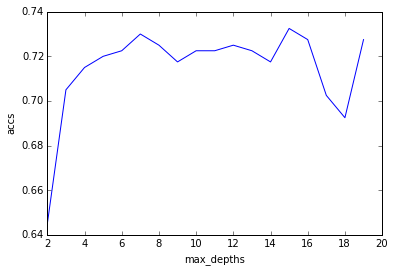

In [50]:
#use cross_validation to choose max_depths
kfold = KFold(X.shape[0],n_folds = 10)
accs = []
max_depths = range(2,20)
for depth in max_depths:
    k_accs = []
    for train,test in kfold: 
        Xtrain,Xtest,ytrain,ytest = X[train],X[test],y[train],y[test]
        dt = tree.DecisionTreeClassifier(max_depth=depth)
        dt.fit(Xtrain,ytrain)
        ypred = dt.predict(Xtest)
        k_accs.append(accuracy_score(ytest,ypred))
    accs.append(np.mean(k_accs))

#plot
plt.plot(max_depths,accs)
plt.xlabel('max_depths')
plt.ylabel('accs')

In [56]:
dt1 = tree.DecisionTreeClassifier(max_depth=8)
dt1.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [60]:
dot_data1 = StringIO()
tree.export_graphviz(dt1,out_file=dot_data1)
g = gv.Source(dot_data1.getvalue())
g.format = 'png'
g.filename = 'tree2'
g.render()

'tree2.png'

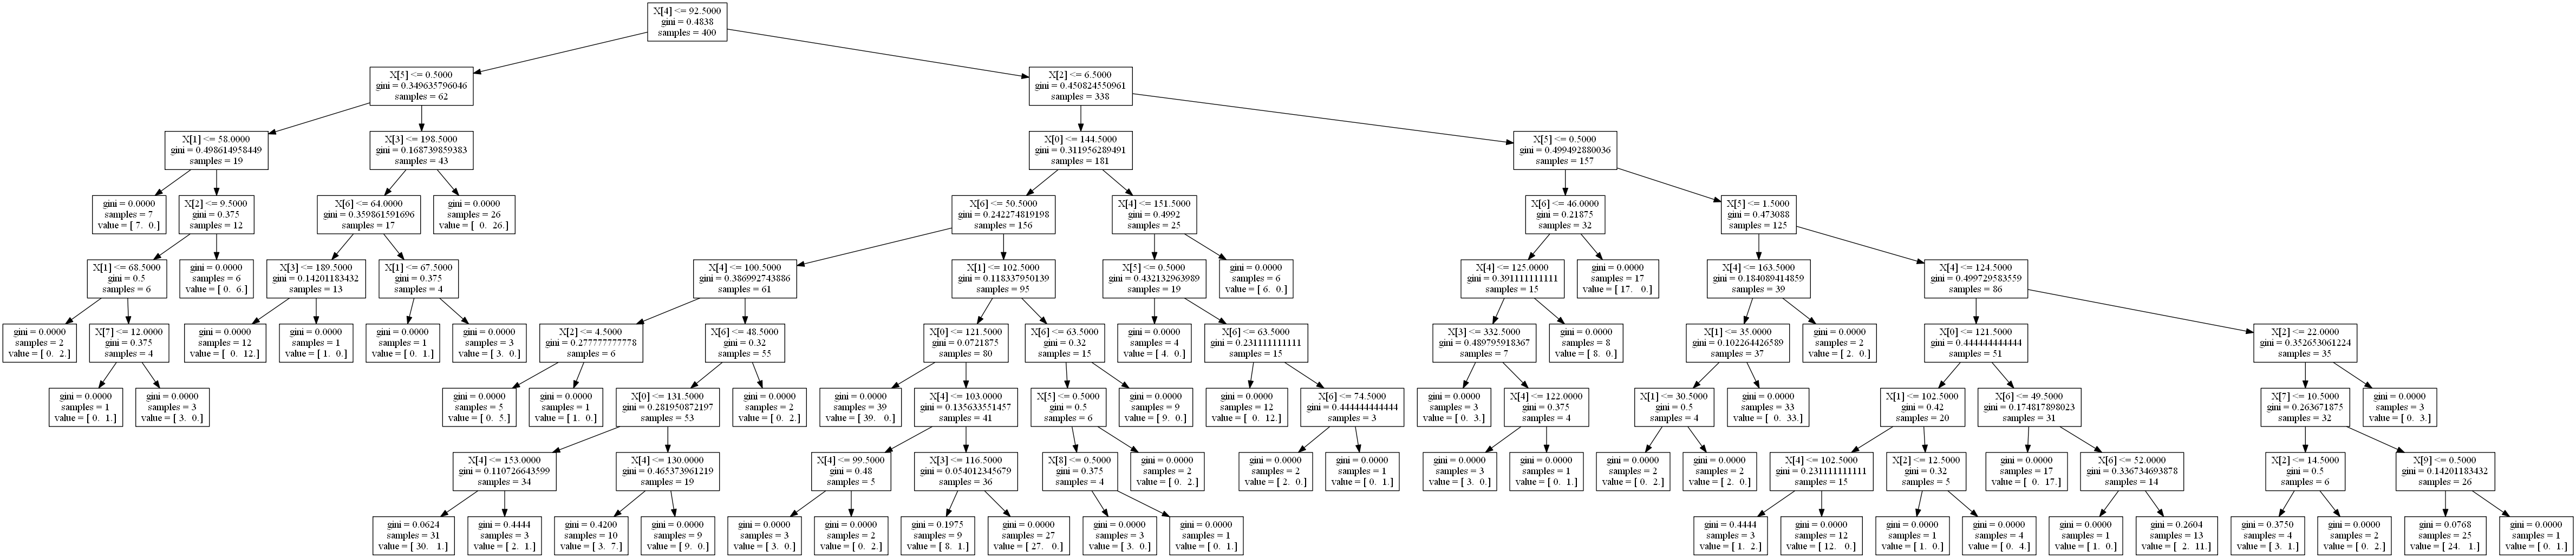

In [61]:
Image('tree2.png')

###Bagging and Random Forests

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
boston_df = pd.read_csv('data/boston.csv')
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
collists = [col for col in boston_df.columns if col != 'medv']
X = boston_df[collists].values
y = boston_df['medv'].values

#Split into training and test sets
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.10,random_state=50)

#Train random forest,beacause it use all features ,so it does equal to Bagging 
rreg = RandomForestRegressor(n_estimators=500,oob_score=True)
rreg.fit(Xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [63]:
# predice
ypred = rreg.predict(Xtest)
mean_squared_error(ypred,ytest),rreg.oob_score_

(10.282416025882357, 0.83836224789347336)

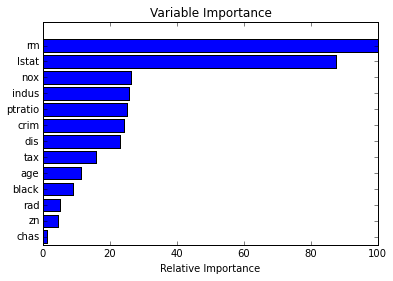

In [94]:
## change max_features = sqrt(all_features) to run randomforest
rreg1 = RandomForestRegressor(n_estimators=500,oob_score=50,max_features='sqrt',random_state=50)
rreg1.fit(Xtrain,ytrain)
ypred = rreg1.predict(Xtest)
mean_squared_error(ypred,ytest),rreg1.oob_score_
#plot feature importance
feature_importance = rreg1.feature_importances_
#make importance relative to max importance
feature_importance = 100.0* (feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos,feature_importance[sorted_idx],align ='center')
cols = [collists[i] for i in sorted_idx]
plt.yticks(pos,cols)
plt.xlabel('Relative Importance')
plt.title("Variable Importance")

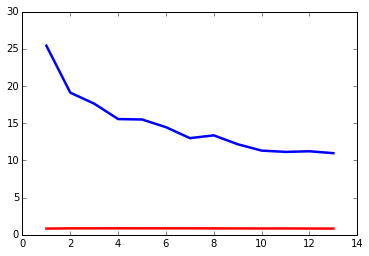

In [71]:
# find best max_features
oob_scores = []
mses = []
num_feats = range(1,14)
for feat in num_feats:
    regx = RandomForestRegressor(n_estimators=500,max_features=feat, oob_score=True)
    regx.fit(Xtrain,ytrain)
    ypred = regx.predict(Xtest)
    mses.append(mean_squared_error(ypred,ytest))
    oob_scores.append(regx.oob_score_)
plt.plot(num_feats,mses,color = 'b',lw = 2.5,label = '$MSES$')
plt.plot(num_feats,oob_scores,color = 'r',lw=2.5,label="$oob$")

###Boosting

In [5]:
from sklearn.ensemble import AdaBoostRegressor

In [12]:
abreg = AdaBoostRegressor(tree.DecisionTreeRegressor(),n_estimators=5000)
abreg.fit(Xtrain,ytrain)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=5000,
         random_state=None)

In [13]:
abreg.feature_importances_

array([ 0.03584219,  0.00116636,  0.01112319,  0.00108029,  0.03722546,
        0.22511298,  0.02768923,  0.08176063,  0.00455017,  0.02328764,
        0.02851284,  0.01494898,  0.50770003])

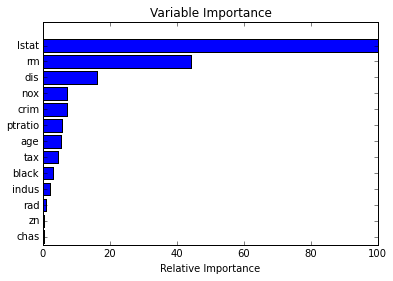

In [15]:
ypred = abreg.predict(Xtest)

#plot feature importance
feature_importance = abreg.feature_importances_
#make importance relative to max importance
feature_importance = 100.0* (feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos,feature_importance[sorted_idx],align ='center')
cols = [collists[i] for i in sorted_idx]
plt.yticks(pos,cols)
plt.xlabel('Relative Importance')
plt.title("Variable Importance")

In [18]:
mean_squared_error(ytest,ypred)

4.3799999999999981